# Model Evaluations

The aim of this notebook is to compare the topic models generated by LDA and BERTopic. To evaluate them, I will be looking at the 'spread' of keywords in the topics generated by the models compared to the entire dataset. 

In order to do this, I will generate 100 randomly selected groups of 100 publications from
1. the entire dataset, 
2. the top 10 topics from LDA, 
3. the top 10 topics from BERTopic 

Then look at the average number of keywords for each set. The basic assumption is: the more sensible a topic, the fewer the number of unique keywords it will contain.

In [1]:
import numpy as np
import pandas as pd

### Importing and cleaning data

In [2]:
# Read in data
data = pd.read_csv('pubmedscrape_full.csv', index_col=0).reset_index(drop=True)
lda = pd.read_csv('lda50_results.csv', index_col=0)
BERTopic = pd.read_csv('manualBERTopic_result.csv', index_col=0)

In [3]:
import string
puncs = string.punctuation

In [4]:
# Fill null citations with 0
data['n_citations'] = data['n_citations'].fillna(0)
data['n_citations'] = data['n_citations'].astype('str')
data['n_citations'] = data['n_citations'].apply(lambda x: x.translate(str.maketrans('', '', puncs)))
data['n_citations'] = data['n_citations'].astype('int64')

In [5]:
# Make each keyword column into clean line of words
data['keywords'] = data['keywords'].apply(lambda x: x.translate(str.maketrans(' ', ' ', puncs)).lower())

In [6]:
# Get the titles and n_citations
data = data[['title', 'n_citations', 'keywords']]

In [7]:
# Add topics_lda into data
data['topics_lda'] = lda['topics_lda']

In [8]:
# Add Topic into data
data['topics_BERTopic'] = BERTopic['Topic']

In [9]:
# Check out data
data.head()

,title,n_citations,keywords,topics_lda,topics_BERTopic
0,Stem cell therapy for neurological disorders -...,5,cell humans nervous system diseases physiopat...,21,-1
1,Neural stem cell therapy-Brief review - PubMed,13,animals cell differentiation physiology cell ...,21,-1
2,Stem Cell Therapy in Heart Diseases - Cell Typ...,35,embryonic stem cells cytology embryonic stem ...,2,16
3,Stem Cell Therapy: A New Therapeutic Option fo...,27,cardiovascular diseases etiology cardiovascul...,41,16
4,Stem Cell Therapy for Multiple Sclerosis - PubMed,8,animals humans multiple sclerosis therapy mye...,41,23


In [10]:
# Remove tailing ' - Pubmed' from title
data['title'] = data['title'].str.rstrip(' - PubMed').tolist()

### How many documents are in each topic?

In [11]:
np.sort(lda['topics_lda'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 16, 17, 18,
       21, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 44, 45, 46, 47, 48, 49], dtype=int64)

In [12]:
# Look at number of documents in LDA topics
lda.groupby('topics_lda').agg('count')['text'].sort_values(ascending=False).reset_index()

,topics_lda,text
0,21,2359
1,44,1562
2,41,1351
3,46,1086
4,31,1012
5,47,735
6,2,669
7,35,407
8,4,230
9,24,161


In [13]:
# Look at number of documents in LDA topics
BERTopic.groupby('Topic').agg('count')['text'].sort_values(ascending=False).reset_index()

,Topic,text
0,-1,2218
1,16,1430
2,40,640
3,0,324
4,17,298
5,2,294
6,33,250
7,35,242
8,21,225
9,25,216


Looking at the topic assignments from each model, we see that the number of documents in each topic is larger for most of the topics from LDA. Perhaps, it will be better to increase the number of components for LDA in the future to make it more comparable to BERTopic. 


I would say this is another advantage for BERTopic because the use of HDBSCAN means that the algorithm will naturally ignore outliers and divide the documents into an optimal number of clusters based on a few parameters. 


A drawback however is that with BERTopic we cannot predetermine the number of clusters. This can be indirectly controlled by adjusting the parameters of HBDSCAN. Since I generated 10 topics for LDA and 48 topics for BERTopic, it is important to note that comparisons between the two are not perfect. For the ease of analysis, I will pick the top 10 topics from BERTopic based on the number of publications to compare with LDA topics.

### Average number of keywords in 100 documents from each topic

In [14]:
# Get number of publications per topic from LDA topics
lda_topics_n_docs = lda.groupby('topics_lda').agg('count')['text'].values
lda_topics = lda.groupby('topics_lda').agg('count')['text'].index

In [15]:
# Get number of publications per topic from BERTopic topics 
BERTopic_topics_n_docs = BERTopic.groupby('Topic').agg('count')['text'].values
BERTopic_topics = BERTopic.groupby('Topic').agg('count')['text'].index

In [16]:
# random number generator without replacement
from numpy.random import default_rng
rng = default_rng()

In [17]:
# Function for assessing uniqueness of 100 (or entire dataframe if len(df) < 100)
#                                            randomly selected documents 100 times
def uniq_kw_len(df):
    
    # Empty list for recording at each i
    df_uniq_kw = []
    
    # Looping through 100 times
    for i in np.arange(100):
        
        try:
            # Generate 100 random index
            idx = rng.choice(len(df), size=100, replace=False)
        
        except:
            # Go through all of the index (for topics with <100 documents)
            idx = df.index
    
        # Extract keywords from dataframe
        uniq_kw = set(' '.join(df.loc[idx, 'keywords']).split(' '))
        
        # Append into list
        df_uniq_kw.append(len(uniq_kw))
    
    # Return the mean value
    return np.mean(df_uniq_kw)

In [52]:
# LDA Topics randomness

# Empty list to store metric
LDA_t = []
t_s

# Loop through each topic and find randomness
for t in lda_topics:
    
    # Filter the dataframe for specific the specific topic
    LDA = data[data['topics_lda']==t].reset_index(drop=True)
    
    # Append the randomness
    LDA_t.append((uniq_kw_len(LDA), t))
    
LDA_metrics = [x[0] for x in LDA_t]

In [19]:
# BERTopics randomness

# Empty list to store metric
BERTopic_metrics = []

# Loop through each topic and find randomness
for t in BERTopic_topics:
    
    # Filter the dataframe for specific the specific topic
    BERTopics = data[data['topics_BERTopic']==t].reset_index(drop=True)
    
    # Append the randomness
    BERTopic_metrics.append(uniq_kw_len(BERTopics)) 

In [20]:
# Get the baseline from entire corpus
baseline = uniq_kw_len(data)

In [21]:
import matplotlib.pyplot as plt

In [22]:
# Words in each topic
lda_topic_words = lda.groupby('topics_lda').first()['words']
BERTopic_topic_words = BERTopic.groupby('Topic').first()['top10words']

In [39]:
len(LDA_metrics)

41

In [37]:
LDA_df = pd.DataFrame({'lda_topic_words':lda_topic_words,
                       'lda_topics':lda_topics,
                       'lda_topics_n_docs':lda_topics_n_docs})

LDA_df['Topic_ID'] = np.arange(1, 42, 1)
LDA_df.reset_index().sort_values('lda_topics_n_docs', ascending=False)
LDA_df

,lda_topic_words,lda_topics,lda_topics_n_docs,Topic_ID
topics_lda,,,,
0,abstract unavailable lymphoma issue end best r...,0,26,1
1,mobilization gcsf peripheral cd34 blood chemot...,1,27,2
2,cardiac heart myocardial cardiomyocytes repair...,2,669,3
3,diabetes pancreatic insulin mellitus diabetic ...,3,3,4
4,cancer tumor cscs tumors breast resistance tar...,4,230,5
5,renal kidney acute chronic fibrosis failure en...,5,1,6
6,infection perspectives transplants translation...,6,6,7
7,spinal cord sci injury motor neural injured re...,7,6,8
8,mscs mesenchymal msc stromal adipose umbilical...,8,18,9


In [24]:
import seaborn as sns
import matplotlib.colors as mcolors

In [25]:
clist = [(0, "blue"), (0.01, "blue"), (0.02, "green"), (0.03, "green"), 
         (0.04, "orange"), (0.05, "red"), (1, "red")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

In [27]:
# Put BERTopic metrics into a dataframe
BERTopic_df = pd.DataFrame({'BERTopic_topic_words': BERTopic_topic_words,
                            'BERTopic_metrics': BERTopic_metrics,
                            'BERTopic_topics_n_docs':BERTopic_topics_n_docs})

# Biggest BERT topic by number of documents
top10BERTopic = BERTopic_df.sort_values('BERTopic_topics_n_docs', ascending=False).head(11).reset_index()
top10BERTopic

,Topic,BERTopic_topic_words,BERTopic_metrics,BERTopic_topics_n_docs
0,-1,outlier,553.53,2218
1,16,heart cardiac myocardial cardiovascular infarc...,387.62,1430
2,40,pluripotent embryonic reprogramming sydney sha...,437.89,640
3,0,retinal eye corneal ophthalmology visual ocula...,396.21,324
4,17,stroke ischemic brain cerebral neurology ich r...,310.04,298
5,2,liver hepatic hepatocytes cirrhosis hepatocyte...,425.70,294
6,33,cancer cscs tumor breast csc resistance tumors...,376.19,250
7,35,imaging tracking mri labeled magnetic labeling...,402.82,242
8,21,lung pulmonary covid respiratory 19 fibrosis a...,387.48,225
9,25,dental pulp oral periodontal dentistry stomato...,391.17,216


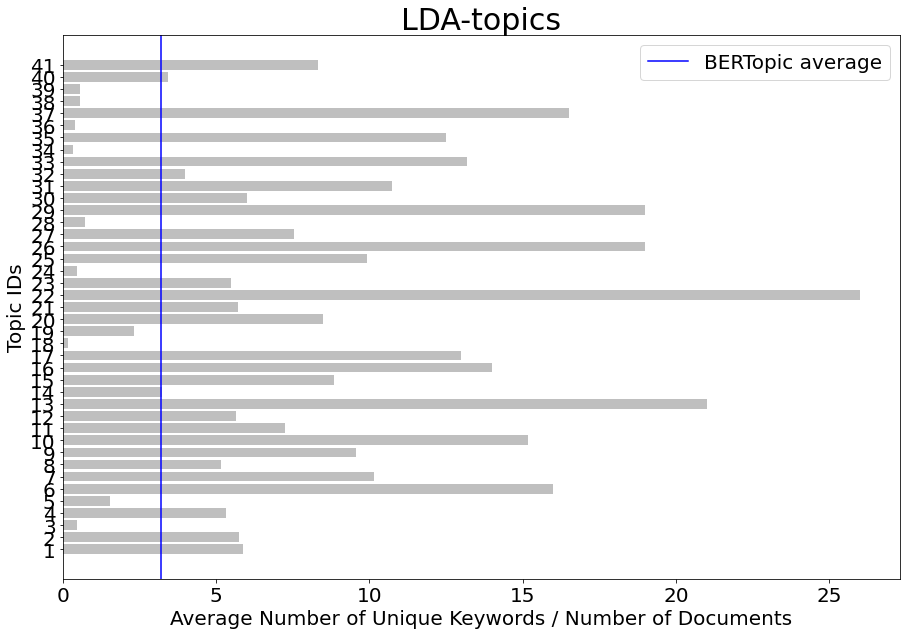

In [28]:
# Plot the average number of keywords
plt.figure(figsize=(15,10))
plt.barh(y=LDA_df['Topic_ID'], width=LDA_metrics/LDA_df['lda_topics_n_docs'], 
         color='grey', 
         alpha=0.5)

plt.yticks(LDA_df['Topic_ID'], fontsize=20)
plt.xlabel('Average Number of Unique Keywords / Number of Documents', fontsize=20)
plt.ylabel('Topic IDs', fontsize=20)
plt.axvline(np.mean(BERTopic_metrics/BERTopic_df['BERTopic_topics_n_docs']), label='BERTopic average', color='blue')
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.title('LDA-topics', size=30)
plt.savefig('LDA_uniquekeywords.png')

The above plot shows the average number of unique keywords for each of the LDA topics. The red line is the baseline calculated from the entire dataset and the blue line is the average of BERTopic topics. All of the LDA topics exceed the average BERTopic number of unique keywords. The diabetes/pancreas topic and the heart topic come quite close. Compared to the baseline we see a 200 word count reduction. 

In [29]:
top10BERTopic.reset_index()[['Topic', 'BERTopic_topic_words']]

,Topic,BERTopic_topic_words
0,-1,outlier
1,16,heart cardiac myocardial cardiovascular infarc...
2,40,pluripotent embryonic reprogramming sydney sha...
3,0,retinal eye corneal ophthalmology visual ocula...
4,17,stroke ischemic brain cerebral neurology ich r...
5,2,liver hepatic hepatocytes cirrhosis hepatocyte...
6,33,cancer cscs tumor breast csc resistance tumors...
7,35,imaging tracking mri labeled magnetic labeling...
8,21,lung pulmonary covid respiratory 19 fibrosis a...
9,25,dental pulp oral periodontal dentistry stomato...


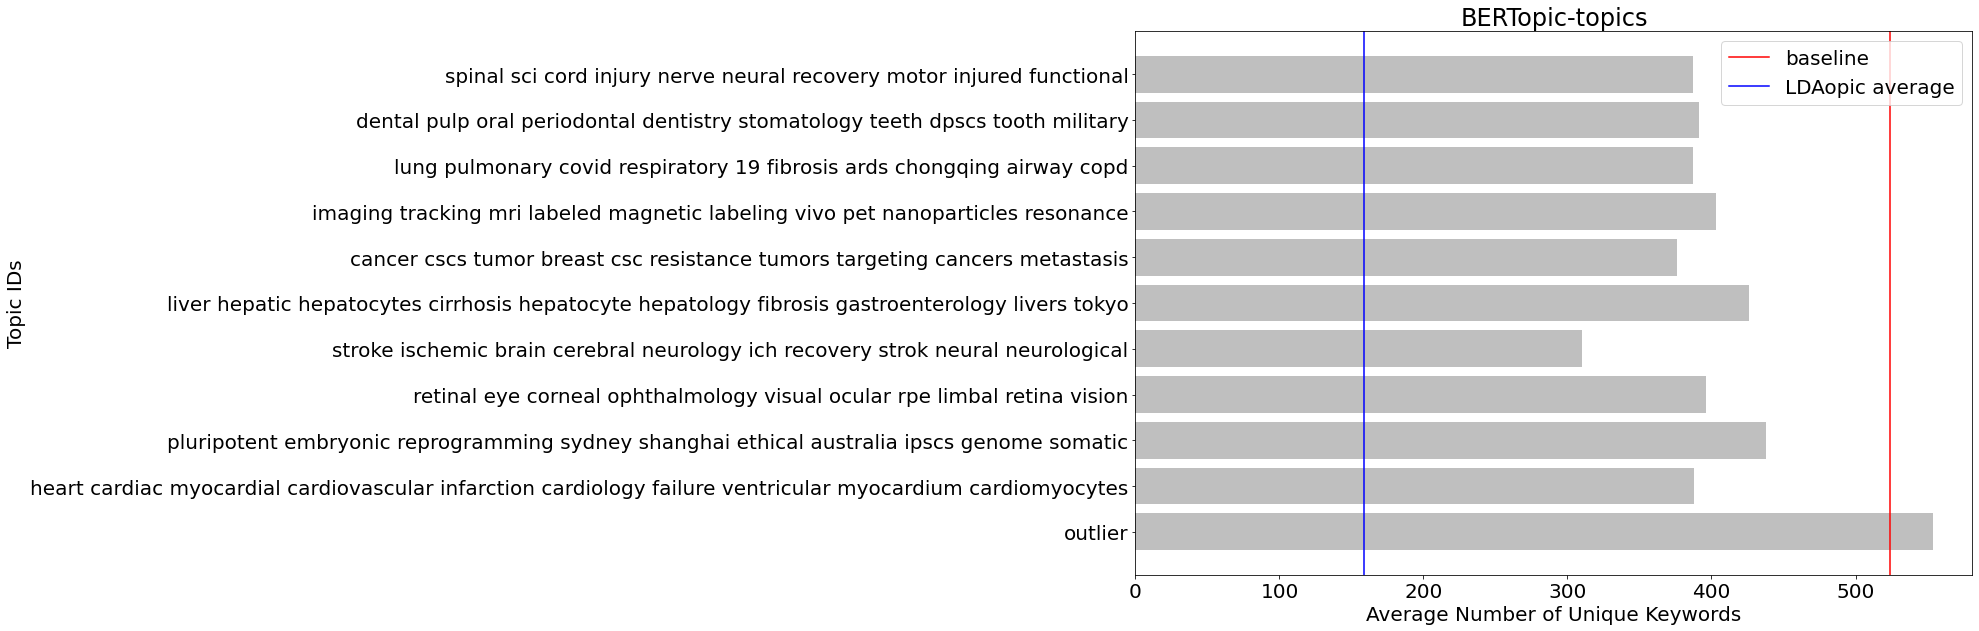

In [30]:
# Plot average number of unique keywords for each BERTopic
plt.figure(figsize=(15,10))
plt.barh(y=top10BERTopic['BERTopic_topic_words'], 
         width=top10BERTopic['BERTopic_metrics'], 
         color='grey', alpha=0.5)
plt.yticks(fontsize=20)
plt.xlabel('Average Number of Unique Keywords', fontsize=20)
plt.ylabel('Topic IDs', fontsize=20)
plt.axvline(baseline, label='baseline', color='red')
plt.axvline(np.mean(LDA_metrics[1:]), label='LDAopic average', color='blue')
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.title('BERTopic-topics', size=24)
plt.savefig('BERTopic_uniquekeywords.png')

Since we only took a sample of topics, let's take a look at all of the topics:

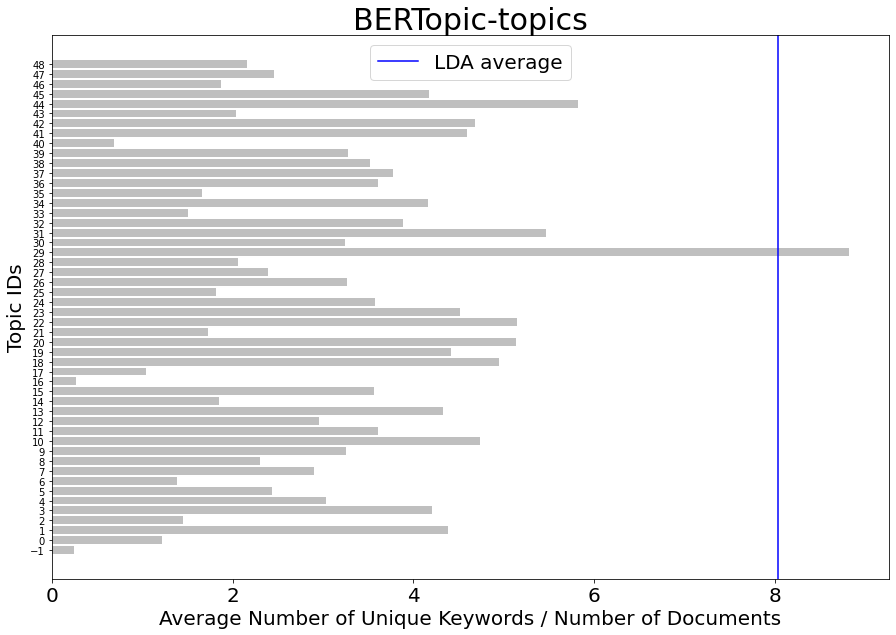

In [31]:
# Plot average number of unique keywords for each BERTopic
plt.figure(figsize=(15,10))
plt.barh(y=BERTopic_df.index, 
         width=BERTopic_df['BERTopic_metrics']/BERTopic_df['BERTopic_topics_n_docs'], 
         color='grey', 
         alpha=0.5)
plt.yticks(BERTopic_df.index, fontsize=10)
plt.xlabel('Average Number of Unique Keywords / Number of Documents', fontsize=20)
plt.ylabel('Topic IDs', fontsize=20)
plt.axvline(np.mean(LDA_metrics/LDA_df['lda_topics_n_docs']), label='LDA average', color='blue')
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
plt.title('BERTopic-topics', size=30)
plt.savefig('BERTopic_uniquekeywords_all.png')

The above plot shows the average number of unique keywords for each of the BERTopic topics. The red line is the baseline calculated from the entire dataset and the blue line is the average of LDA topics. All of the BERTopic topics score below the average LDA number of unique keywords but the outlier, which also exceeded the baseline. 

I see some similar topics in both models. Let's take a few examples and take a look at the most cited publications from each to compare.

In [32]:
# A function that prints the top 3
def top_cited_in_topics(topic_id, model, topic):
    
    if model == 'LDA':
        # Get the top cited titles from lda_topic 
        LDA_titles = data[data['topics_lda']==topic_id].sort_values('n_citations', 
                                                                    ascending=False)['title'].head(5).values
        return print(f'Top cited "{topic}" titles from LDA: \n\n -', '\n - '.join(LDA_titles.tolist()))
    elif model == 'BERTopic':
        # Get the top cited titles from 
        BERTopic_titles = data[data['topics_BERTopic']==topic_id].sort_values('n_citations', 
                                                                              ascending=False)['title'].head(5).values
        return print(f'Top cited "{topic}" titles from BERTopic: \n\n -', '\n - '.join(BERTopic_titles.tolist()))

In [33]:
# Heart
LDA_heart = 2
BERTopic_heart = 16

top_cited_in_topics(LDA_heart, 'LDA', 'HEART')
print('\n')
top_cited_in_topics(BERTopic_heart, 'BERTopic', 'HEART')

Top cited "HEART" titles from LDA: 

 - Stem-cell therapy for cardiac diseas
 - Paracrine mechanisms of mesenchymal stem cell-based therapy: current status and perspectives
 - Secreted frizzled related protein 2 (Sfrp2) is the key Akt-mesenchymal stem cell-released paracrine factor mediating myocardial survival and repair
 - Exosomes: vehicles of intercellular signaling, biomarkers, and vectors of cell therapy
 - Mesenchymal stem cell exosome: a novel stem cell-based therapy for cardiovascular diseas


Top cited "HEART" titles from BERTopic: 

 - Stem-cell therapy for cardiac diseas
 - Assessing identity, phenotype, and fate of endothelial progenitor cells
 - Paracrine mechanisms of mesenchymal stem cell-based therapy: current status and perspectives
 - Controversies in ventricular remodelling
 - Secreted frizzled related protein 2 (Sfrp2) is the key Akt-mesenchymal stem cell-released paracrine factor mediating myocardial survival and repair


Both models spat out relevant publications about therapies for heart diseases. The top cited title from both are the same. 

In [34]:
# Imaging
LDA_img = 32
BERTopic_img = 35

top_cited_in_topics(LDA_img, 'LDA', "IMAGING")
print('\n')
top_cited_in_topics(BERTopic_img, 'BERTopic', "IMAGING")

Top cited "IMAGING" titles from LDA: 

 - Superparamagnetic iron oxide nanoparticles as MRI contrast agents for non-invasive stem cell labeling and tracking
 - Labeling stem cells with superparamagnetic iron oxide nanoparticles: analysis of the labeling efficacy by microscopy and magnetic resonance imaging
 - Monitoring stem cell therapy in vivo using magnetodendrimers as a new class of cellular MR contrast agents
 - Magnetic Resonance Imaging of Iron Oxide-Labeled Human Embryonic Stem Cell-Derived Cardiac Progenitors
 - Tracking the migration of cardially delivered therapeutic stem cells in vivo: state of the art


Top cited "IMAGING" titles from BERTopic: 

 - In vivo visualization of embryonic stem cell survival, proliferation, and migration after cardiac delivery
 - In vivo MRI cell tracking: clinical studies
 - Noninvasive cell-tracking methods
 - Superparamagnetic iron oxide nanoparticles as MRI contrast agents for non-invasive stem cell labeling and tracking
 - Quantitative meta

For imaging, the LDA topic seems more confused than BERTopic. The top cited publications in the topic are a mix of themes. While the publications in BERTopic are consistently about visualizations and cell tracking methods through MRI and imaging. 

In [35]:
# Cancer
LDA_cancer = 4
BERTopic_cancer = 33

top_cited_in_topics(LDA_cancer, 'LDA', "CANCER")
print('\n')
top_cited_in_topics(BERTopic_cancer, 'BERTopic', "CANCER")

Top cited "CANCER" titles from LDA: 

 - Wnt/β-Catenin Signaling, Disease, and Emerging Therapeutic Modalities
 - The stem-cell niche as an entity of action
 - Heterogeneity in cancer: cancer stem cells versus clonal evolution
 - Visualization and targeting of LGR5 + human colon cancer stem cells
 - Prostate cancer stem cells: a new target for therapy


Top cited "CANCER" titles from BERTopic: 

 - Cancer stem cells revisit
 - Heterogeneity in cancer: cancer stem cells versus clonal evolution
 - Unravelling cancer stem cell potential
 - Stem cell origin of cancer and differentiation therapy
 - Visualization and targeting of LGR5 + human colon cancer stem cells


In the cancer-related topics, again the top cited publications in the LDA topic is less about cancer than the BERTopic topic, where all five publications are cancer related. 

### Summary

Comparing LDA- and BERTopic-generated topics by the number of unique keywords in each topic and the top cited titles, we saw that BERTopic topics were more specific to the overarching topic. It is important to note, this may not be the fairest comparison because the LDA model was generated to divide the publications into 10 groups, while in BERTopic, the algorithm generated 48 topics. In the future, I would like to generate the same number of topics and repeat the comparison. In terms of the computation power, BERTopic is a lot more intensive. For now, it seems like a superior model, however, if fine tuning the parameters in LDA can achieve groupings that make sense as much as BERTopic, it would be preferred if GPUs are not available. 

In [56]:
uniq_kw_BERT = BERTopic_df['BERTopic_metrics']/BERTopic_df['BERTopic_topics_n_docs']
uniq_kw_LDA = LDA_metrics/LDA_df['lda_topics_n_docs']

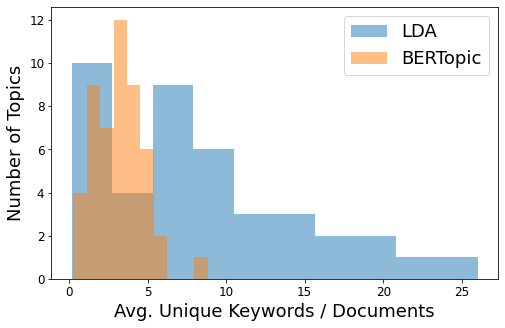

In [66]:
plt.figure(figsize=(8, 5))
plt.hist(uniq_kw_LDA, label='LDA', alpha=0.5)
plt.hist(uniq_kw_BERT, label='BERTopic', alpha=0.5)
plt.legend(fontsize=18)
plt.ylabel('Number of Topics', fontsize=18)
plt.xlabel('Avg. Unique Keywords / Documents', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Model_topics_comparison.png')

In [74]:
df_umap = pd.read_csv('UMAP2D_HBDSCAN_results.csv', index_col=0)

In [75]:
df_umap

,x,y,labels
0,5.513296,9.835733,-1
1,5.696035,9.352124,-1
2,-4.101680,8.069302,16
3,-3.767354,8.267690,16
4,6.547939,10.291307,23
...,...,...,...
9921,0.927546,12.303159,39
9922,1.479054,14.389464,48
9923,1.710579,14.775417,47
9924,-3.526964,1.911277,6


In [73]:
df_umap

,x,y,labels,Topic
0,5.513296,9.835733,-1,-1
1,5.696035,9.352124,-1,-1
2,-4.101680,8.069302,16,16
3,-3.767354,8.267690,16,16
4,6.547939,10.291307,23,23
...,...,...,...,...
9921,0.927546,12.303159,39,39
9922,1.479054,14.389464,48,48
9923,1.710579,14.775417,47,47
9924,-3.526964,1.911277,6,6


In [91]:
df_umap['Words'] = None

In [99]:
idx = df_umap.reset_index().groupby('labels').first()['index']

In [114]:
words = BERTopic_df['BERTopic_topic_words'].str.split(' ').apply(lambda x: (' ').join(x[:1])).values

In [115]:
df_umap.loc[idx, 'Words'] = words

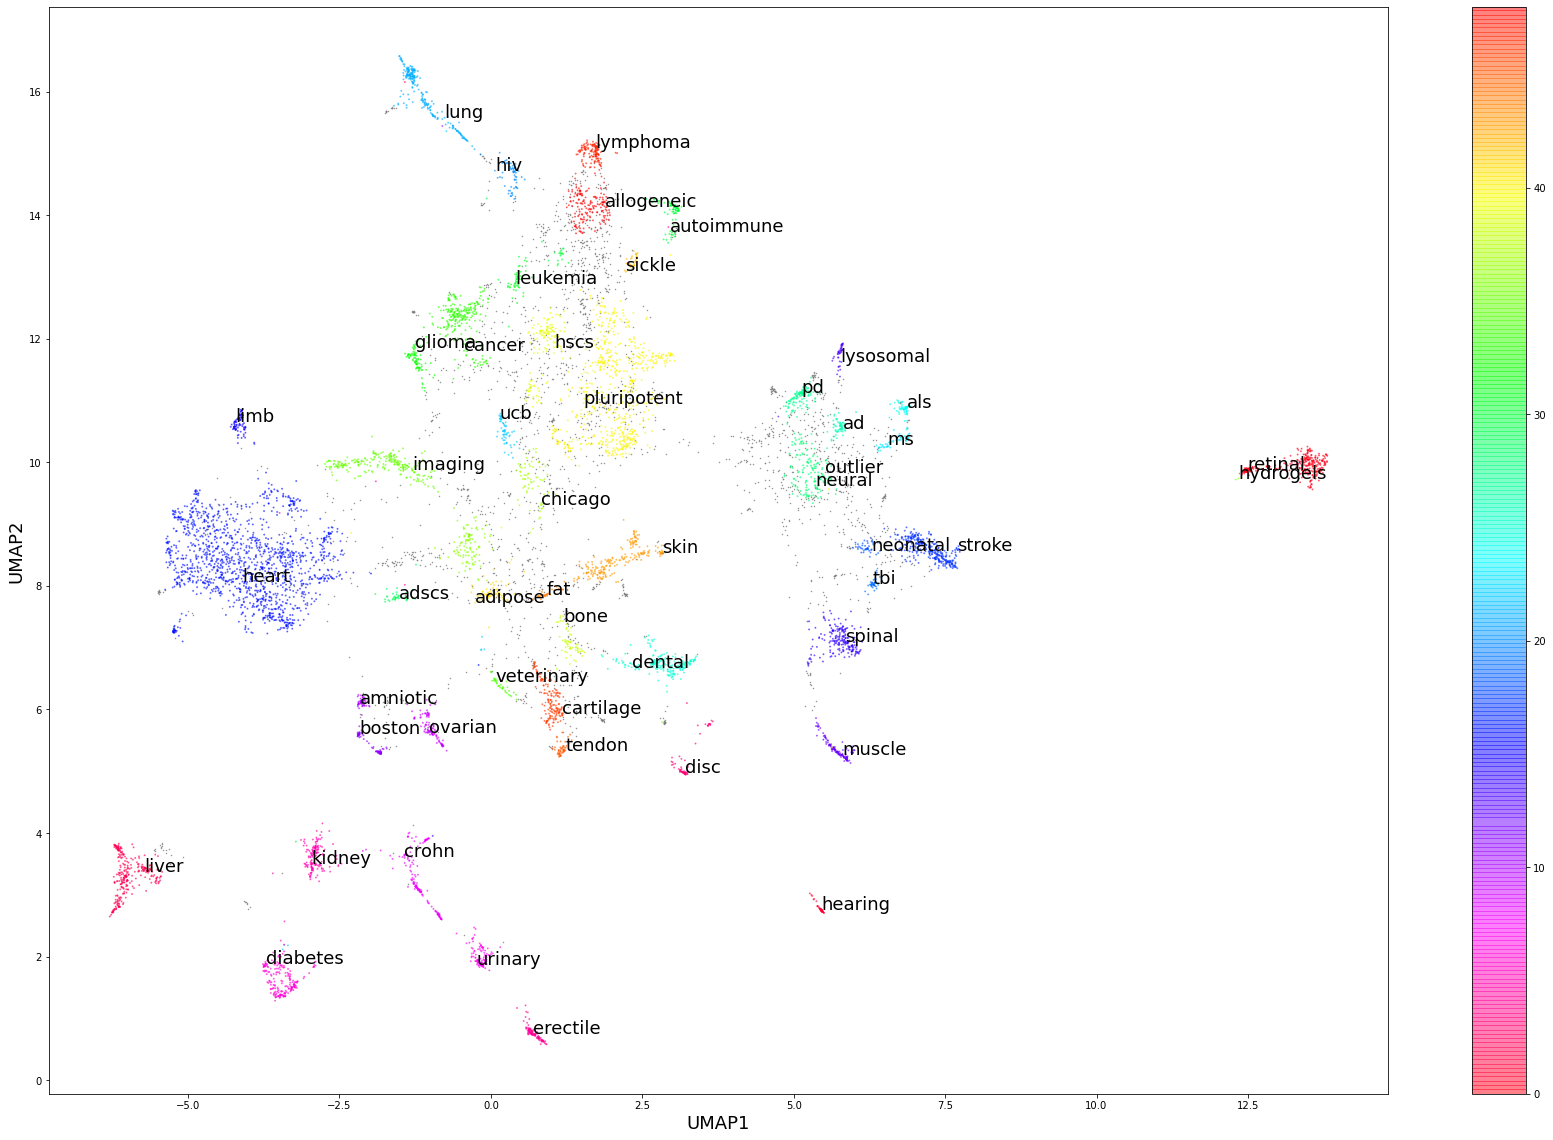

In [116]:
# Separate outliers from cluserts
outliers = df_umap.loc[df_umap['labels']==-1, :]
clustered = df_umap.loc[df_umap['labels']!=-1, :]

import matplotlib.pyplot as plt

plt.figure(figsize=(30,20))
plt.scatter(outliers['x'], outliers['y'], color='gray', s=0.2)
plt.scatter(clustered['x'], clustered['y'], c=clustered['labels'], cmap='hsv_r', s=1, alpha=0.5)
plt.xlabel('UMAP1', fontsize=18)
plt.ylabel('UMAP2', fontsize=18)

for i in idx:
    x = df_umap['x'][i]
    y = df_umap['y'][i]
    s = df_umap['Words'][i]
    plt.text(x, y, s, fontsize=18)

plt.colorbar()
plt.savefig('UMAP_Plot.png')